In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
#add other imports as needed

In [2]:
import os

In [3]:
import platform

# Set file location based on platform. 
platstring = platform.platform()
if ('Darwin' in platstring) or ('macOS' in platstring):
    # macOS 
    data_root = "/Volumes/TReND2024/"
elif 'Windows'  in platstring:
    # Windows (replace with the drive letter of USB drive)
    data_root = "E:/"
elif ('amzn' in platstring):
    # then on Code Ocean
    data_root = "/data/"
else:
    # then your own linux platform
    # EDIT location where you mounted hard drive
    data_root = "/media/$USERNAME/TReND2024/"

Use the code block below to access the Two-Photon Calcium Imaging data set.  This is what we used in the tutorials.

In [4]:
from allensdk.core.brain_observatory_cache import BrainObservatoryCache

manifest_file = os.path.join(data_root,'allen-brain-observatory/visual-coding-2p/manifest.json')

boc = BrainObservatoryCache(manifest_file=manifest_file)

Use code below to access Neuropixels data set.  This is electrophysiological data.  It is very similar to the data set we demonstrated, but has important differences, both in the science and in the access methods used in the python tools.

In [5]:
from allensdk.brain_observatory.ecephys.ecephys_project_cache import EcephysProjectCache

manifest_path = os.path.join(data_root,'allen-brain-observatory/visual-coding-neuropixels/ecephys-cache/manifest.json') 

cache = EcephysProjectCache.from_warehouse(manifest=manifest_path)

/opt/conda/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [6]:
cell_id = 517425536
sessions= boc.get_ophys_experiments(cell_specimen_ids =[cell_id], stimuli=['static_gratings'])
len(sessions)

1

In [7]:
data_set = boc.get_ophys_experiment_data(sessions[0]["id"])

In [8]:
cell_index = data_set.get_cell_specimen_indices([cell_id])

cell_index

[55]

In [9]:
timestamps, dff = data_set.get_dff_traces() # get cell responses in the dataset

In [10]:
stim_table = data_set.get_stimulus_table("static_gratings")
# remove blank screen readings
stim_table = stim_table[stim_table["orientation"].isna() == False]

stim_table.head()

,orientation,spatial_frequency,phase,start,end
0,150.0,0.02,0.75,747,754
2,0.0,0.16,0.25,762,769
3,30.0,0.16,0.25,769,776
4,0.0,0.16,0.00,777,784
5,150.0,0.02,0.75,784,791


In [11]:
# get stimulus epochs
stim_epochs = data_set.get_stimulus_epoch_table()
stim_epochs

,stimulus,start,end
0,static_gratings,747,15193
1,natural_scenes,16096,30550
2,spontaneous,30700,39581
3,natural_scenes,39582,54029
4,static_gratings,54933,69378
5,natural_movie_one,70282,79312
6,natural_scenes,80215,96092
7,static_gratings,97372,113624


In [12]:
dff_traces = dff[cell_index]

In [13]:
dff_traces = dff_traces[0]

dff_traces.shape

(113850,)

Text(0, 0.5, 'DFF (%)')

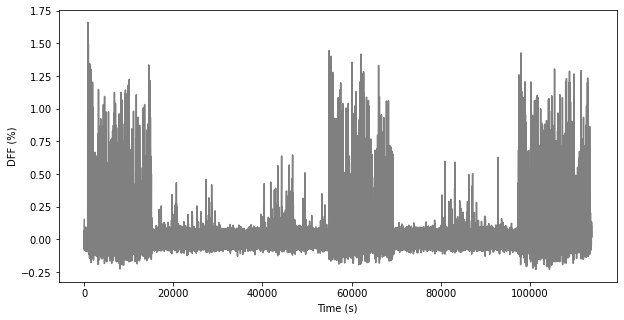

In [14]:
fig = plt.figure(figsize=(10,5))
plt.plot(dff_traces, color='gray')
plt.xlabel("Time (s)")
plt.ylabel("DFF (%)")

In [15]:
# get the cell's response per trial
response = pd.DataFrame(columns=('orientation','spatial_frequency','trial_response'), index=stim_table.index.values)

response['orientation'] = stim_table.orientation
response['spatial_frequency'] = stim_table.spatial_frequency

pd.options.mode.copy_on_write = True #this let's us write into the dataframe 

for ind,row_stim in stim_table.iterrows():
    response.loc[ind, 'trial_response'] = dff_traces[int(row_stim.start):int(row_stim.end)].mean()

In [16]:
response.head()

,orientation,spatial_frequency,trial_response
0,150.0,0.02,0.008848
2,0.0,0.16,0.040173
3,30.0,0.16,0.005824
4,0.0,0.16,-0.04306
5,150.0,0.02,-0.037968


Text(0, 0.5, 'Mean DF/F')

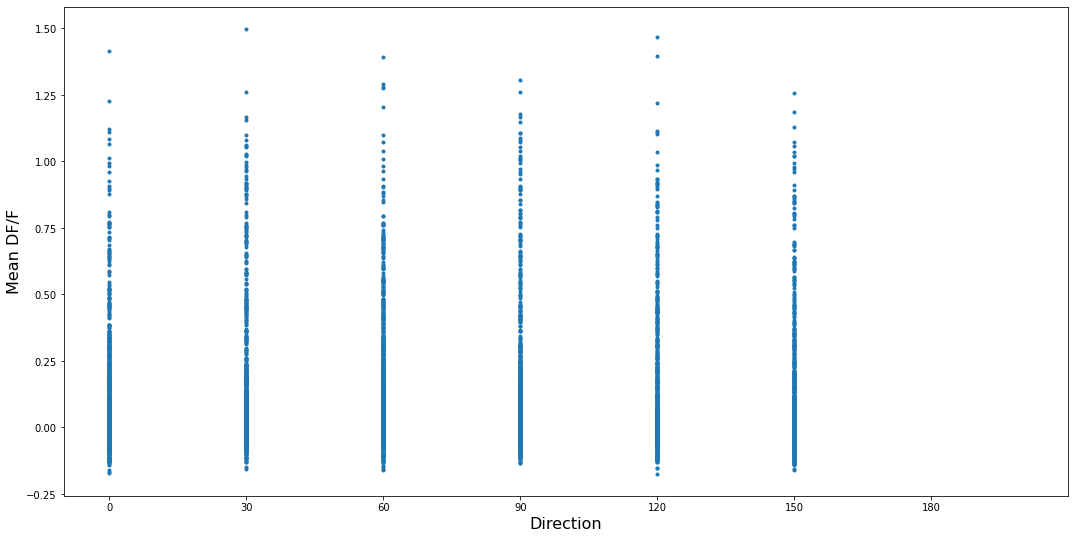

In [17]:
fig = plt.figure(figsize=(18,9))
plt.plot(response.orientation.values, response.trial_response.values, '.')
plt.xticks(range(0,210,30))
plt.xlim(-10,210)
plt.xlabel("Direction", fontsize=16)
plt.ylabel("Mean DF/F", fontsize=16)

Text(0, 0.5, 'Mean DF/F')

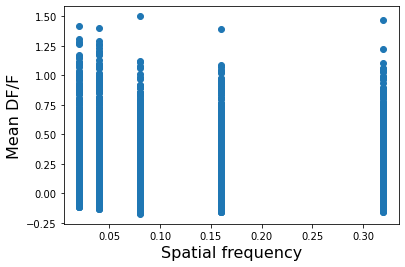

In [18]:
plt.plot(response.spatial_frequency.values, response.trial_response.values, 'o')
plt.xlabel("Spatial frequency", fontsize=16)
plt.ylabel("Mean DF/F", fontsize=16)

In [19]:
# get unique orientations

all_ori = np.sort(stim_table.orientation.unique())
orivals = all_ori[np.isfinite(all_ori)]
print(orivals)

[  0.  30.  60.  90. 120. 150.]


In [20]:
np.sort(stim_table.orientation.dropna().unique())

array([  0.,  30.,  60.,  90., 120., 150.], dtype=float32)

In [21]:
# orientation tuning

tuning = np.empty((6))
for i, ori in enumerate(orivals):
    trials = response[response.orientation==ori]
    tuning[i] = trials.trial_response.mean()
    #tuning[i] = response[response.orientation==ori].trial_response.mean()

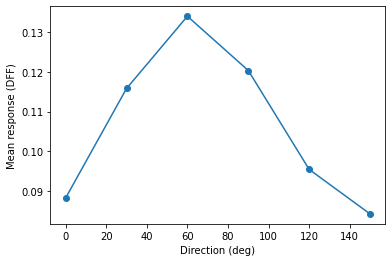

In [22]:
# plot tuning curve

plt.plot(orivals,tuning, 'o-')
plt.xlabel("Direction (deg)")
plt.ylabel("Mean response (DFF)")

tuning_std=np.empty(6)
for i, ori in enumerate (orivals):
    trials = response[response.orientation==ori]
    tuning_std[i]=trials.trial_response.std()

# plt.errorbar(orivals, tuning, yerr=tuning_std, fmt='o-')

<ErrorbarContainer object of 3 artists>

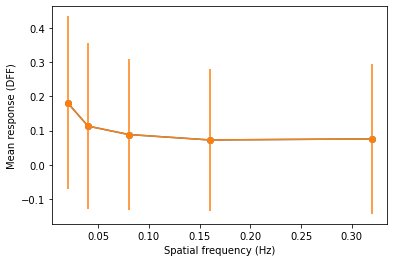

In [23]:
# tuning for spatial frequency

sfvals = np.sort(stim_table.spatial_frequency.unique())
sfvals = sfvals[np.isfinite(sfvals)]

tuning_sf = np.empty((len(sfvals)))
for i,sf in enumerate(sfvals):
    trials = response[response.spatial_frequency==sf]
    tuning_sf[i] = trials.trial_response.mean()
    
plt.plot(sfvals, tuning_sf, 'o-')
plt.xlabel("Spatial frequency (Hz)")
plt.ylabel("Mean response (DFF)")

tuning_std=np.empty(5)
for i, sf in enumerate (sfvals):
    trials = response[response.spatial_frequency==sf]
    tuning_std[i]=trials.trial_response.std()

plt.errorbar(sfvals, tuning_sf, yerr=tuning_std, fmt='o-')

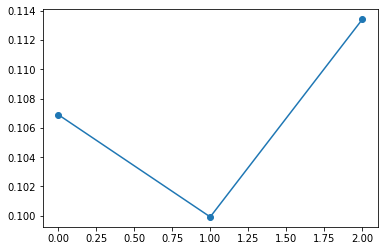

In [39]:
# plot mean response for stimulus exposure
static_gratings_epochs = stim_epochs.loc[stim_epochs["stimulus"] == "static_gratings"].reset_index(drop=True);

stim_epochs_mean_responses = np.empty(len(static_gratings_epochs.index))

for index, epoch in static_gratings_epochs.iterrows():
    stim_epochs_mean_responses[index] = dff_traces[int(epoch.start):int(epoch.end)].mean()
        
plt.plot(stim_epochs_mean_responses, "-o")